# Task 4 Detection of face mask 
(Level - Intermediate)



## Model making

Import necessary packages

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import cv2
%matplotlib inline

 initialize the initial learning rate, number of epochs to train for,
 and batch size

In [ ]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

Clone the images file for git use the below code
* `https://github.com/prajnasb/observations.git`
* Use the command `!git clone https://github.com/prajnasb/observations.git`

In [ ]:
!git clone https://github.com/prajnasb/observations.git

Cloning into 'observations'...
remote: Enumerating objects: 1638, done.
remote: Total 1638 (delta 0), reused 0 (delta 0), pack-reused 1638
Receiving objects: 100% (1638/1638), 75.94 MiB | 18.50 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [ ]:
!mv /content/observations/experiements/data/ /content/

In [ ]:
IMG_PATH = "/content/data/"

In [ ]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(IMG_PATH))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

[INFO] loading images...


Perform one hot encoding on labels

In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

Partition the data into training and testing splits using 80% of
the data for training and the remaining 20% for testing

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

construct the training image generator for data augmentation

In [ ]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

 Load the MobileNetV2 network, ensuring the head FC layer sets are
 left off

In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 0s 0us/step


 Construct the head of the model that will be placed on top of the
 the base model

In [ ]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

Place the head FC model on top of the base model (this will become
 the actual model we will train)

In [ ]:
model = Model(inputs=baseModel.input, outputs=headModel)

Loop over all layers in the base model and freeze them so they will
 *not* be updated during the first training process

In [ ]:
for layer in baseModel.layers:
	layer.trainable = False

Compile the model

In [ ]:
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


Train the head of the network

In [ ]:
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
34/34 [==============================] - 34s 920ms/step - loss: 0.4612 - accuracy: 0.8352 - val_loss: 0.1933 - val_accuracy: 0.9746
Epoch 2/20
34/34 [==============================] - 31s 895ms/step - loss: 0.1772 - accuracy: 0.9579 - val_loss: 0.1000 - val_accuracy: 0.9819
Epoch 3/20
34/34 [==============================] - 31s 895ms/step - loss: 0.0957 - accuracy: 0.9860 - val_loss: 0.0687 - val_accuracy: 0.9855
Epoch 4/20
34/34 [==============================] - 31s 898ms/step - loss: 0.0689 - accuracy: 0.9878 - val_loss: 0.0519 - val_accuracy: 0.9891
Epoch 5/20
34/34 [==============================] - 30s 896ms/step - loss: 0.0545 - accuracy: 0.9916 - val_loss: 0.0445 - val_accuracy: 0.9891
Epoch 6/20
34/34 [==============================] - 31s 900ms/step - loss: 0.0458 - accuracy: 0.9888 - val_loss: 0.0371 - val_accuracy: 0.9891
Epoch 7/20
34/34 [==============================] - 31s 897ms/step - loss: 0.0415 - accuracy: 0.9906 - val_loss: 0.034

 Make predictions on the testing set

In [ ]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

For each image in the testing set we need to find the index of the
label with corresponding largest predicted probability

In [ ]:
predIdxs = np.argmax(predIdxs, axis=1)

Show a nicely formatted classification report

In [ ]:
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

Serialize the model to disk

In [ ]:
print("[INFO] saving mask detector model...")
model.save("/content/mask_detector.model", save_format="h5")

[INFO] saving mask detector model...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
MASK_PATH = "/content/mask_detector.model"

Plot the training vs accuracy graph

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])

Load our serialized face detector model from disk

In [ ]:
%mkdir /content/face_detector

Use the below link to download the code

The below is the caffe file to face_detector folder 
> `res10_300x300_ssd_iter_140000.caffemodel`


> from https://github.com/gopinath-balu/computer_vision/tree/master/CAFFE_DNN







In [ ]:
!wget https://raw.githubusercontent.com/gopinath-balu/computer_vision/master/CAFFE_DNN/deploy.prototxt.txt -P /content/face_detector/

--2021-06-20 16:46:23--  https://raw.githubusercontent.com/gopinath-balu/computer_vision/master/CAFFE_DNN/deploy.prototxt.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28092 (27K) [text/plain]
Saving to: ‘/content/face_detector/deploy.prototxt.txt’

deploy.prototxt.txt 100%[===================>]  27.43K  --.-KB/s    in 0.001s  

2021-06-20 16:46:23 (45.8 MB/s) - ‘/content/face_detector/deploy.prototxt.txt’ saved [28092/28092]



Converting the deploy.prototxt.txt to deploy.prototxt

In [ ]:
%mv /content/face_detector/deploy.prototxt.txt /content/face_detector/deploy.prototxt

In [ ]:
FACE_PATH = "/content/face_detector/"

In [ ]:
print("[INFO] loading face detector model...")
prototxtPath = os.path.sep.join([FACE_PATH, "deploy.prototxt"])
weightsPath = os.path.sep.join([FACE_PATH,
	"res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)

[INFO] loading face detector model...


Load the face mask detector model from disk

In [ ]:
print("[INFO] loading face mask detector model...")
model = load_model(MASK_PATH)

[INFO] loading face mask detector model...


Load the input image from disk, clone it, and grab the image spatial
dimensions

In [ ]:
WITHMASK_PATH = "/content/data/with_mask/"
WITHOUTMASK_PATH = "/content/data/without_mask/"

In [ ]:
with_mask_img = [WITHMASK_PATH+fil for fil in os.listdir(WITHMASK_PATH)[0:4]] 
without_mask_img = [WITHOUTMASK_PATH+fil for fil in os.listdir(WITHOUTMASK_PATH)[0:4]]

In [ ]:
EXAMPLE_PATH = with_mask_img+without_mask_img

In [ ]:
print(EXAMPLE_PATH)

['/content/data/with_mask/285-with-mask.jpg', '/content/data/with_mask/augmented_image_232.jpg', '/content/data/with_mask/27-with-mask.jpg', '/content/data/with_mask/103-with-mask.jpg', '/content/data/without_mask/augmented_image_232.jpg', '/content/data/without_mask/79.jpg', '/content/data/without_mask/119.jpg', '/content/data/without_mask/augmented_image_16.jpg']


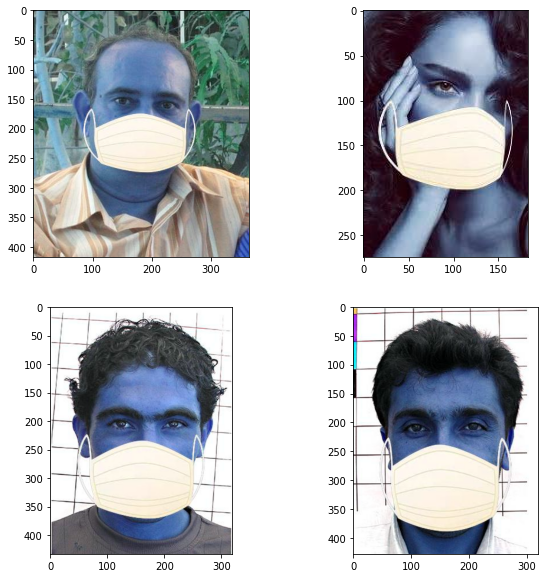

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))

axs[0, 0].imshow(cv2.imread(with_mask_img[0],))

axs[0, 1].imshow(cv2.imread(with_mask_img[1]))

axs[1, 0].imshow(cv2.imread(with_mask_img[2]))

axs[1, 1].imshow(cv2.imread(with_mask_img[3]))

plt.show()

In [ ]:
def face_mask_detect(image):
  blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
	(104.0, 177.0, 123.0))
  print("[INFO] computing face detections...")
  net.setInput(blob)
  detections = net.forward()
  # loop over the detections
  CONFI = 0.8
  for i in range(0, detections.shape[2]):
	  confidence = detections[0, 0, i, 2]
	  # filter out weak detections by ensuring the confidence is
	  # greater than the minimum confidence
	  if confidence > CONFI:
		  # compute the (x, y)-coordinates of the bounding box for
		  # the object
		  box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		  (startX, startY, endX, endY) = box.astype("int")
		  # ensure the bounding boxes fall within the dimensions of
		  # the frame
		  (startX, startY) = (max(0, startX), max(0, startY))
		  (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
  		# extract the face ROI, convert it from BGR to RGB channel
		  # ordering, resize it to 224x224, and preprocess it
		  face = image[startY:endY, startX:endX]
		  face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
		  face = cv2.resize(face, (224, 224))
		  face = img_to_array(face)
		  face = preprocess_input(face)
		  face = np.expand_dims(face, axis=0)
		  # pass the face through the model to determine if the face
		  # has a mask or not
		  (mask, withoutMask) = model.predict(face)[0]
    		# determine the class label and color we'll use to draw
		  # the bounding box and text
		  label = "Mask" if mask > withoutMask else "No Mask"
		  color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
		  # include the probability in the label
		  label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
		  # display the label and bounding box rectangle on the output
		  # frame
		  cv2.putText(image, label, (startX, startY - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		  cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

  plt.imshow(image)


[INFO] computing face detections...


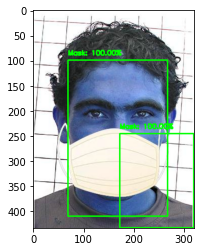

In [ ]:
img = with_mask_img[2]
image = cv2.imread(img)
orig = image.copy()
(h, w) = image.shape[:2]
face_mask_detect(image)